In [2]:
import numpy as np
import math
import itertools
import matplotlib.pyplot as plt
import csv
import seaborn as sns
import pandas as pd
from tqdm.notebook import tqdm

# Importing standard Qiskit libraries
# from ibm_quantum_widgets import CircuitComposer
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, transpile, Aer, IBMQ, opflow, execute
from qiskit.circuit import Parameter, ParameterVector
from qiskit.quantum_info import Statevector
import qiskit.quantum_info as qi
from qiskit.providers.aer import AerSimulator
from qiskit.providers.ibmq import least_busy
from qiskit.result import Result
from qiskit.providers.aer.noise import *
from qiskit.tools.jupyter import *
from qiskit.visualization import *
# from ibm_quantum_widgets import *
from scipy.optimize import minimize

#fake backend for noisy simulation
from qiskit.providers.fake_provider import FakeMumbai

### Number of qubits = $5$

In [20]:
n = 5
U_prep_angle = (2*math.pi)/3

In [21]:
fid_dict=[]
fid_no_pad_dict=[]

In [22]:
theta=ParameterVector('θ',length=2*n)
fid_no_pad = [dict() for x in range(9)]
fidelity = [dict() for x in range(9)]
theta_para = [dict() for x in range(9)]
theta_para1 = [dict() for x in range(9)]
theta_para2 = [dict() for x in range(9)]
csv_column1=['Gate_1', 'Gate_2', 'Delay', 'Fidelity','θ1', "θ2","θ3","θ4","θ5","θ1'", "θ2'","θ3'","θ4'","θ5'"]
csv_column3=['Gate_1', 'Gate_2', 'Delay', 'Fidelity']
csv_file1 = "Delay_vs_Fidelity.csv"
csv_file3 = "Delay_vs_Fidelity_No_Padding.csv"

def binseq(k):
    return [''.join(x) for x in itertools.product('01', repeat=k)]

In [23]:
def d_vs_fidelity_no_pad(n, circuit, prob, delay):
    T1 = 117600 # in ns
    T2 = 111400 
    noise_model = NoiseModel()
    err = thermal_relaxation_error(T1,T2,delay)
    err1 = thermal_relaxation_error(T1,T2,431)
    err2 = err1.tensor(err1)
    err3 = thermal_relaxation_error(T1,T2,300)
    noise_model.add_all_qubit_quantum_error(err, ['delay'])
    noise_model.add_all_qubit_quantum_error(err3, ['h','x','ry','rx'])
    noise_model.add_all_qubit_quantum_error(err2, ['cx'])
    backend = AerSimulator(noise_model=noise_model)
    count = backend.run(circuit,shots=1024).result().get_counts()
    sum=0.0
    for x in binseq(n):
        temp=prob[x] if (x in prob.keys()) else 0
        temp=temp*(count[x]/1024 if (x in count.keys()) else 0.0)
        sum=sum+math.sqrt(temp)
    return sum*sum

In [24]:
def d_vs_fidelity(n, circuit, prob, delay):
    T1 = 117600 # in ns
    T2 = 111400 
    noise_model = NoiseModel()
    err = thermal_relaxation_error(T1,T2,delay)
    err1 = thermal_relaxation_error(T1,T2,431)
    err2 = err1.tensor(err1)
    err3 = thermal_relaxation_error(T1,T2,300)
    noise_model.add_all_qubit_quantum_error(err, ['delay'])
    noise_model.add_all_qubit_quantum_error(err3, ['h','x','ry','rx'])
    noise_model.add_all_qubit_quantum_error(err2, ['cx'])
    def evaluate_fidelity(theta1):
        backend = AerSimulator(noise_model=noise_model)
        count = backend.run(circuit.assign_parameters({theta: theta1}),shots=1024).result().get_counts()
        sum=0.0
        for x in binseq(n):
            temp=prob[x] if (x in prob.keys()) else 0
            temp=temp*(count[x]/1024 if (x in count.keys()) else 0.0)
            sum=sum+math.sqrt(temp)
        return -(sum*sum)
    initial_point = np.random.random(circuit.num_parameters)
    return minimize(evaluate_fidelity, initial_point, method='COBYLA')

In [30]:
def main_test(n,U_prep_angle):
    qreg_q = QuantumRegister(n, 'q')
    circuit1 = QuantumCircuit(qreg_q)
    circuit1.ry(U_prep_angle, qreg_q[0])
    for i in range(0,n-1):
        circuit1.cx(qreg_q[i], qreg_q[i+1])
    prob = Statevector(Aer.get_backend('statevector_simulator').run(circuit1, shots=1).result().get_statevector()).probabilities_dict()    
    for t in tqdm(range(0,200000,1000)):
        for u in range(0,3):
            for v in range(0,3):
                    
                #U with Ry gate if u=0, Rx gate if u=1 and Rz gate if u=2
                U = QuantumCircuit(qreg_q)
                U.barrier()
                for i in range(n):
                    U.h(qreg_q[i])
                    U.x(qreg_q[i])
                    U.h(qreg_q[i])

                U.barrier()
                if u==0:
                    for qubit in range(0,n):
                        U.ry(theta[qubit], qreg_q[qubit])
                elif u==1:
                    for qubit in range(0,n):
                        U.rx(theta[qubit], qreg_q[qubit])
                else:
                    for qubit in range(0,n):
                        U.rz(theta[qubit], qreg_q[qubit])

                U.barrier()

                #delay gates
                D = QuantumCircuit(qreg_q)
                D.delay(t,unit='ns')
                D.barrier()
                    
                # V = QuantumCircuit(qreg_q)
                # V = U.inverse()

                V = QuantumCircuit(qreg_q)
                if v==0:
                    for qubit in range(0,n):
                        V.ry(theta[n+qubit], qreg_q[qubit])
                elif v==1:
                    for qubit in range(0,n):
                        V.rx(theta[n+qubit], qreg_q[qubit])
                else:
                    for qubit in range(0,n):
                        V.rz(theta[n+qubit], qreg_q[qubit])

                V.barrier()
                
                for i in range(n):
                    V.h(qreg_q[i])
                    V.x(qreg_q[i])
                    V.h(qreg_q[i])

                    
                #finding fidelity (for a given circuit, and delay time) when not using any sort of padding
                circuit=circuit1.compose(D)
                circuit.measure_all()
                opt1=d_vs_fidelity_no_pad(n, circuit, prob, t)
                fid_no_pad[(u*3+v)].update({t : opt1})
                fid_no_pad_dict.append({'Gate_1' : u, 'Gate_2' : v, 'Delay' : t, 'Fidelity' : opt1})
                
                # #creating the circuit
                circuit=circuit1.compose(U.compose(D.compose(V)))
                circuit.measure_all()
                
                # #saving optimal theta1, theta2 and fidelity for a given circuit and delay time
                opt=d_vs_fidelity(n, circuit, prob, t)
                fidelity[(u*3+v)].update({t : -opt['fun']})
                theta_para[(u*3+v)].update({t : opt['x'][0]/opt['x'][1]})
                theta_para1[(u*3+v)].update({t : opt['x'][0]})
                theta_para2[(u*3+v)].update({t : opt['x'][1]})
                fid_dict.append({'Gate_1' : u, 'Gate_2' : v, 'Delay' : t, 'Fidelity' : -opt['fun'], "θ1": opt['x'][0] , "θ2": opt['x'][1] , "θ3": opt['x'][2] ,"θ4": opt['x'][3] , "θ5": opt['x'][4], "θ1'": opt['x'][5] , "θ2'": opt['x'][6] , "θ3'": opt['x'][7] ,"θ4'": opt['x'][8] , "θ5'": opt['x'][9]})
                # fid_dict.append({'Gate_1' : u, 'Gate_2' : v, 'Delay' : t, 'Fidelity' : -opt['fun']})
                # theta1_vs_theta2_dict.append({'Gate_1' : u, 'Gate_2' : v, 'Delay' : t, 'θ1' : opt['x'][0], 'θ2': opt['x'][1]})
                # ratio_dict.append({'Gate_1' : u, 'Gate_2' : v, 'Delay' : t, 'θ1/θ2' : opt['x'][0]/opt['x'][1]})


### Test code before running

In [28]:
qreg_q = QuantumRegister(n, 'q')
circuit1 = QuantumCircuit(qreg_q)
circuit1.ry(U_prep_angle, qreg_q[0])
for i in range(0,n-1):
    circuit1.cx(qreg_q[i], qreg_q[i+1])
prob = Statevector(Aer.get_backend('statevector_simulator').run(circuit1, shots=1).result().get_statevector()).probabilities_dict()    
for t in tqdm(range(0,1000,1000)):
    for u in range(1):
        for v in range(1):
                
            #U with Ry gate if u=0, Rx gate if u=1 and Rz gate if u=2
            U = QuantumCircuit(qreg_q)
            U.barrier()
            for i in range(n):
                U.h(qreg_q[i])
                U.x(qreg_q[i])
                U.h(qreg_q[i])

            U.barrier()
            if u==0:
                for qubit in range(0,n):
                    U.ry(theta[qubit], qreg_q[qubit])
            elif u==1:
                for qubit in range(0,n):
                    U.rx(theta[qubit], qreg_q[qubit])
            else:
                for qubit in range(0,n):
                    U.rz(theta[qubit], qreg_q[qubit])

            U.barrier()

            #delay gates
            D = QuantumCircuit(qreg_q)
            D.delay(t,unit='ns')
            D.barrier()
                
            # V = QuantumCircuit(qreg_q)
            #V = U.inverse()
            V = QuantumCircuit(qreg_q)

            if v==0:
                for qubit in range(0,n):
                    V.ry(theta[n+qubit], qreg_q[qubit])
            elif v==1:
                for qubit in range(0,n):
                    V.rx(theta[n+qubit], qreg_q[qubit])
            else:
                for qubit in range(0,n):
                    V.rz(theta[n+qubit], qreg_q[qubit])    

            V.barrier()
            
            for i in range(n):
                V.h(qreg_q[i])
                V.x(qreg_q[i])
                V.h(qreg_q[i])

            
            #finding fidelity (for a given circuit, and delay time) when not using any sort of padding
            circuit=circuit1.compose(D)
            circuit.measure_all()
            opt1=d_vs_fidelity_no_pad(n, circuit, prob, t)
            # fid_no_pad[(u*3+v)].update({t : opt1})
            # fid_no_pad_dict.append({'Gate_1' : u, 'Gate_2' : v, 'Delay' : t, 'Fidelity' : opt1})
            
            # #creating the circuit
            circuit=circuit1.compose(U.compose(D.compose(V)))
            circuit.measure_all()
            
            # #saving optimal theta1, theta2 and fidelity for a given circuit and delay time
            opt=d_vs_fidelity(n, circuit, prob, t)
            # fidelity[(u*3+v)].update({t : -opt['fun']})
            # theta_para[(u*3+v)].update({t : opt['x'][0]/opt['x'][1]})
            # theta_para1[(u*3+v)].update({t : opt['x'][0]})
            # theta_para2[(u*3+v)].update({t : opt['x'][1]})
            print(opt['x'][5])
            # fid_dict.append({'Gate_1' : u, 'Gate_2' : v, 'Delay' : t, 'Fidelity' : -opt['fun'], "θ1": opt['x'][0] , "θ2": opt['x'][1] , "θ3": opt['x'][2] ,"θ4": opt['x'][3] , "θ5": opt['x'][4]})
            # print(opt['x'][4])'θ1', "θ2","θ3","θ4","θ5"
            # theta1_vs_theta2_dict.append({'Gate_1' : u, 'Gate_2' : v, 'Delay' : t, 'θ1' : opt['x'][0], 'θ2': opt['x'][1]})
            # ratio_dict.append({'Gate_1' : u, 'Gate_2' : v, 'Delay' : t, 'θ1/θ2' : opt['x'][0]/opt['x'][1]})

  0%|          | 0/1 [00:00<?, ?it/s]

0.29294862051142084


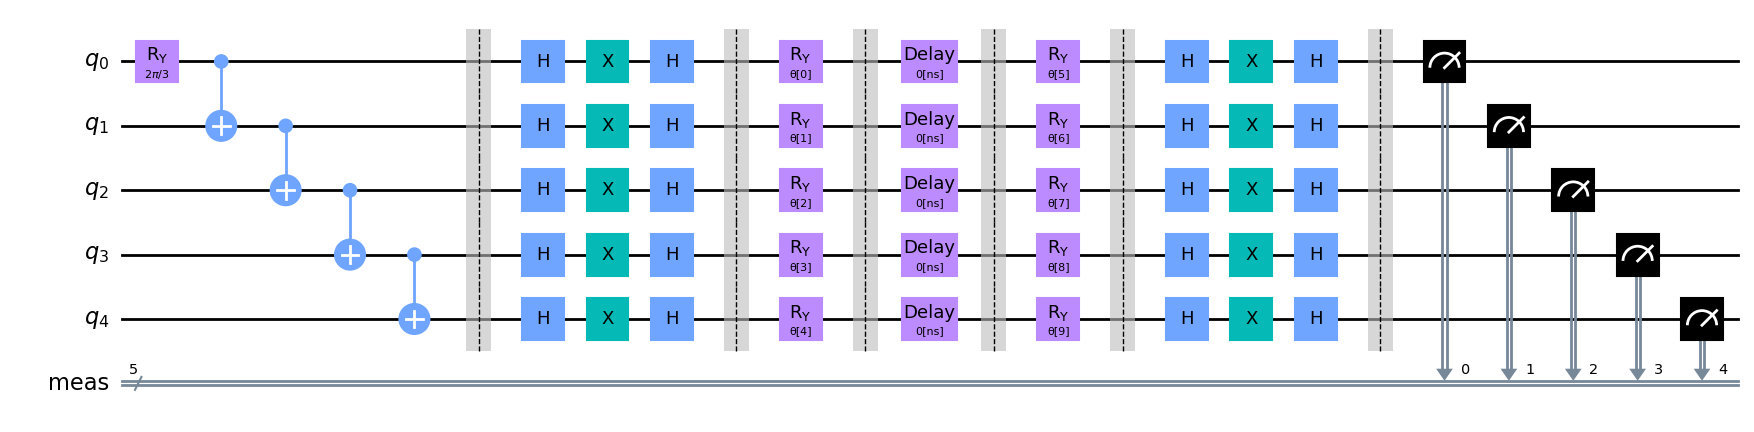

In [29]:
circuit.draw('mpl')

In [32]:
main_test(n,U_prep_angle)

  0%|          | 0/200 [00:00<?, ?it/s]

In [33]:
def plot_graphs():
    try:
        with open(csv_file1, 'w') as csvfile:
            writer = csv.DictWriter(csvfile, fieldnames=csv_column1)
            writer.writeheader()
            for data in fid_dict:
                writer.writerow(data)
    except IOError:
        print("I/O error")
    try:
        with open(csv_file3, 'w') as csvfile:
            writer = csv.DictWriter(csvfile, fieldnames=csv_column3)
            writer.writeheader()
            for data in fid_no_pad_dict:
                writer.writerow(data)
    except IOError:
        print("I/O error")

    fig,ax = plt.subplots(3,3,figsize=(24,16))
    fig.suptitle("Delay vs Fidelity 5 qubits, different theta, U and V")
    for u in range(3):
        for v in range(3):
            if u==0:
                a='Ry(θ)'
            elif u==1:
                a='Rx(θ)'
            else:
                a='Rz(θ)'
            if v==0:
                b="Ry(θ')"
            elif v==1:
                b="Rx(θ')"
            else:
                b="Rz(θ')"
            ax[u][v].set_title(str(a+' and '+b))
            ax[u][v].scatter(list(fidelity[(u*3+v)].keys()),list(fidelity[(u*3+v)].values()), label='With Padding')
            ax[u][v].scatter(list(fid_no_pad[(u*3+v)].keys()),list(fid_no_pad[(u*3+v)].values()), c='b', label='W/o padding')
            ax[u][v].plot(list(fid_no_pad[(u*3+v)].keys()),list(fid_no_pad[(u*3+v)].values()), c='b')
            ax[u][v].set_xlabel('Delay')
            ax[u][v].set_ylabel('Fidelity')
            ax[u][v].set_ylim([0, 1])
            ax[u][v].legend()

    # data2 = pd.DataFrame(ratio_dict, columns=csv_column4)
    # fig,ax = plt.subplots(3,3,figsize=(24,16))
    # fig.suptitle('Delay vs θ1/θ2')
    # for u in range(3):
    #     for v in range(3):
    #         if u==0:
    #             a='Ry(θ1)'
    #         elif u==1:
    #             a='Rx(θ1)'
    #         else:
    #             a='Rz(θ1)'
    #         if v==0:
    #             b='Ry(θ2)'
    #         elif v==1:
    #             b='Rx(θ2)'
    #         else:
    #             b='Rz(θ2)'
    #         ax[u][v].set_title(str(a+' and '+b))
    #         ax[u][v].set_ylim([-15, 15])
    #         sns.regplot(x = "Delay", y = "θ1/θ2", data = (data2.loc[(data2['Gate_1'] == u) & (data2['Gate_2'] == v)])[['Delay', 'θ1/θ2']],ax=ax[u][v])

    # plt.style.use("ggplot")
    # plt.show()

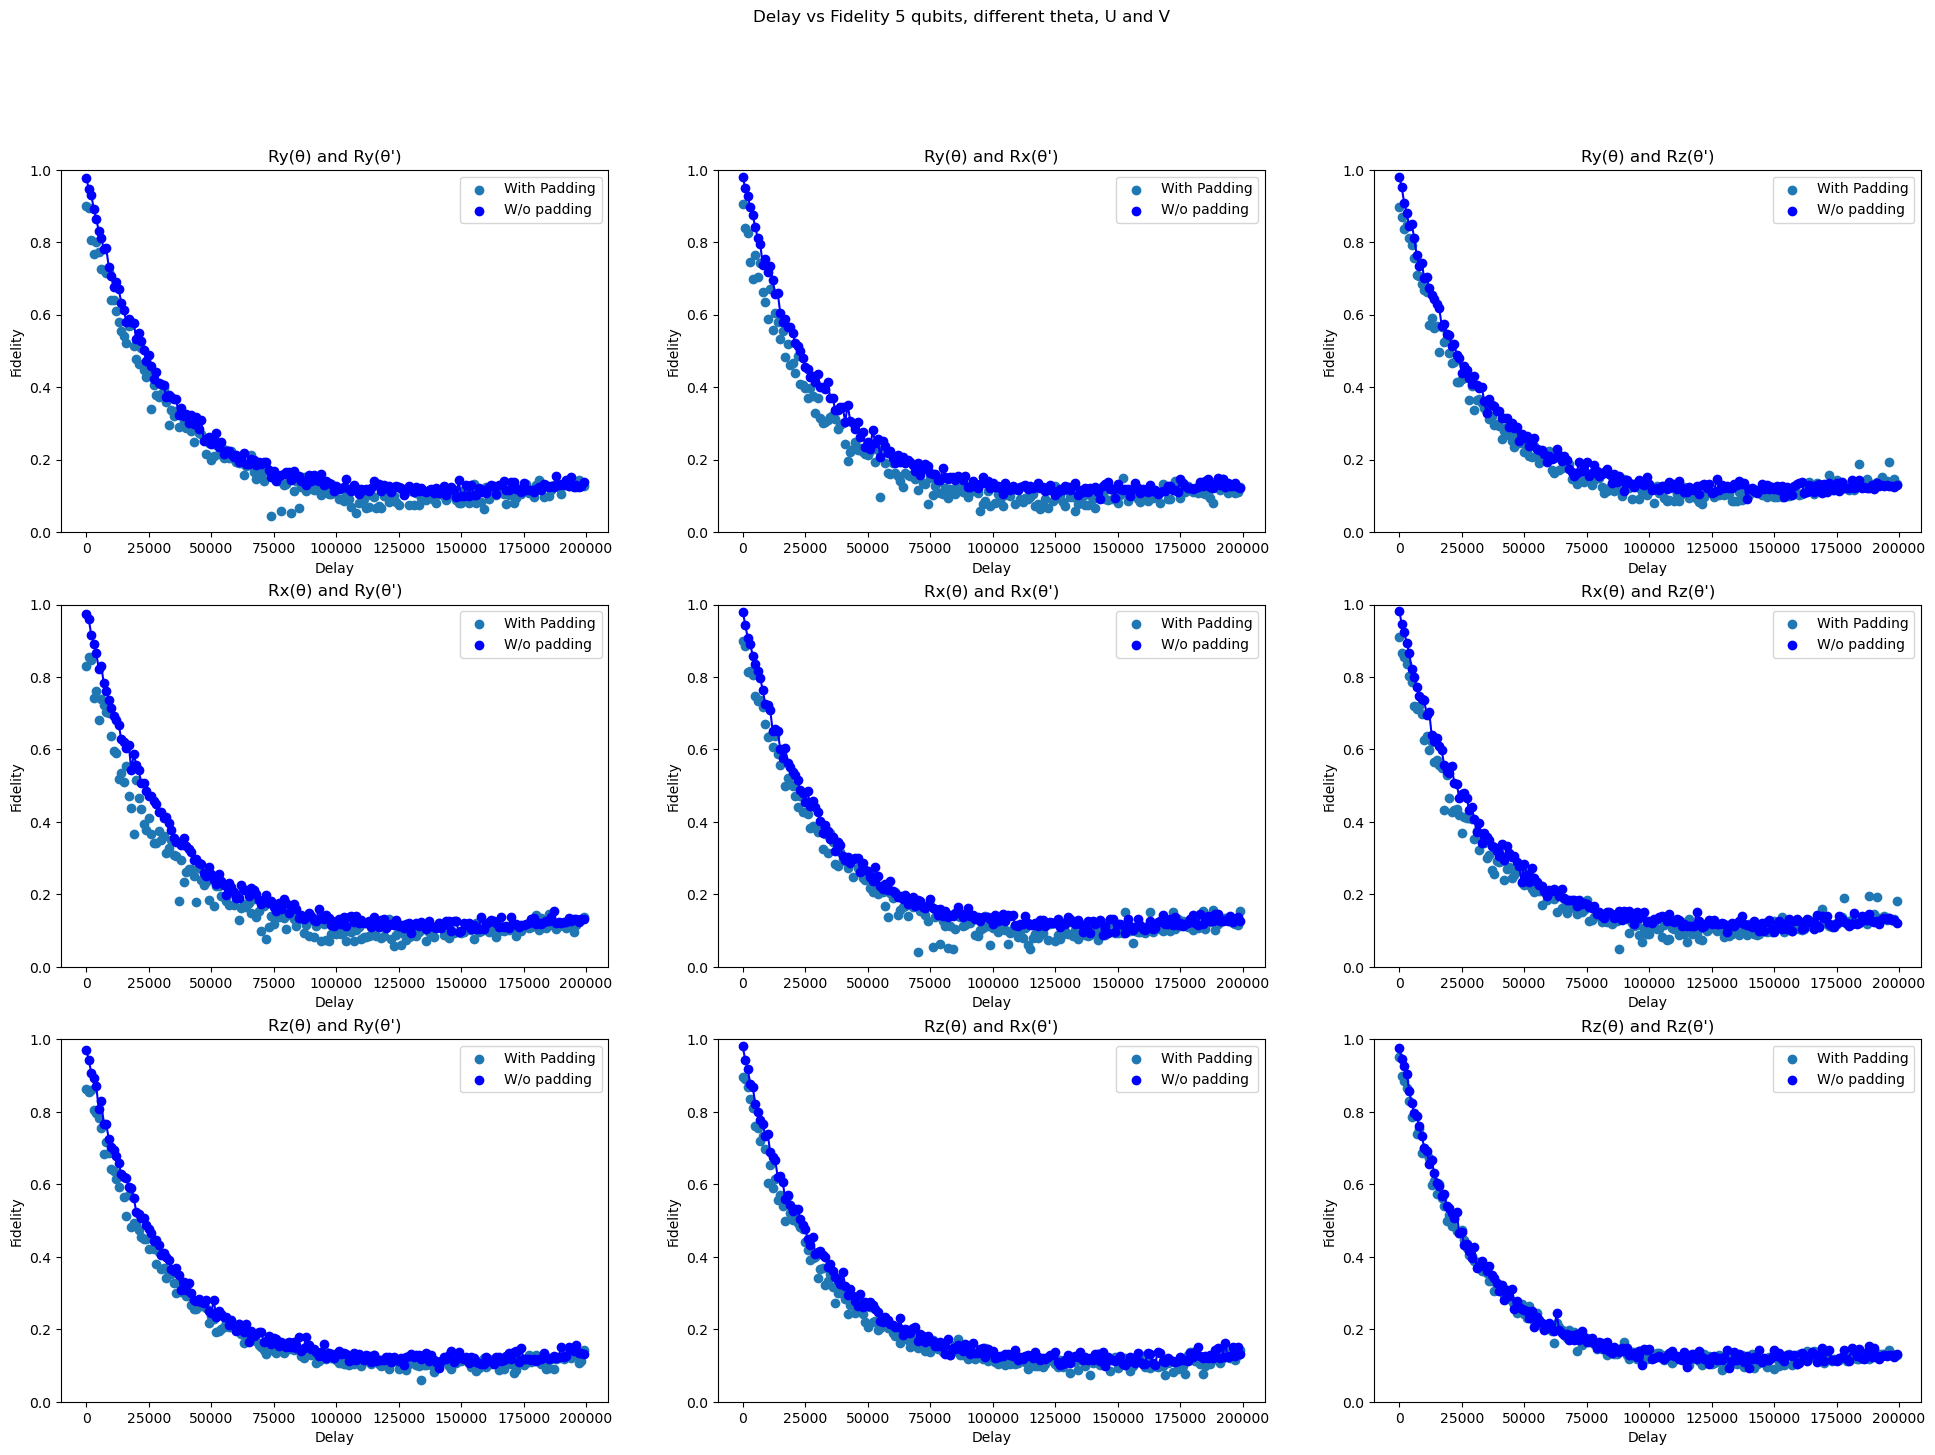

In [34]:
plot_graphs()